# Homework 5

##### Data: chall.txt

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 13th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators


**Joe Davison**
<br>
**Anna Davydova**
<br>
**Michael S. Emanuel**
<br>
**Dylan Randle**
<br>

<div class="answer-separator">
------------------------
</div>

In [2]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [3]:
# Additional imports
import os
from numpy import sqrt, exp, pi
from scipy.integrate import cumtrapz
from scipy.interpolate import PchipInterpolator
from scipy.stats import norm, expon
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

C:\Python\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Utility functions

def arange_inc(x: float, y: float = None, z: float = None) -> np.ndarray:
    """Return a numpy arange inclusive of the end point, i.e. range(start, stop + 1, step)"""
    if y is None:
        (start, stop, step) = (1, x + 1, 1)
    elif z is None:
        (start, stop, step) = (x, y + 1, 1)
    elif z > 0:
        (start, stop, step) = (x, y + 1, z)
    elif z < 0:
        (start, stop, step) = (x, y - 1, z)
    return np.arange(start, stop, step)

# Set default font size to 20
matplotlib.rcParams.update({'font.size': 20})

## Question 1: We'll Always Have that Night Sampling in Monte Carlo

**Coding required**


Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Inverse Transform Sampling

**1.2.** Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)


In [5]:
# Compute  𝔼[h(X)]E[h(X)]  via Monte Carlo simulation using the following sampling methods:
# (1.1) Inverse Transform Sampling
# (1.2) Rejection Sampling with a uniform proposal distribution

# 1. Shared prerequisites for problem 1 (both parts)
def f_X(x: float) -> float:
    """The PDF for problem 1"""
    if x < 1:
        return 0
    elif x <= 3:
        return (1/12) * (x - 1)
    elif x <= 5:
        return (1/12) * (5 -x)
    elif x <= 7:
        return (1/6) * (x-5)
    elif x <= 9:
        return (1/6) * (9-x)
    else:
        return 0


def h(x: float) -> float:
    """The function h(X) whose expectation we want to take"""
    # The normalizing constant
    a: float = 1.0 / (3 * sqrt(2) * pi)
    # The term in the exponential
    u: float = -(1/18)*(x-5)*(x-5)
    return a * exp(u)


def expectation_mc(h, x_sample):
    """Take the expectation of a function given samples
    h:          The function whose expectation we want to take
    x_sample:   The samples of the function
    """
    # Evaluate h(x) on the samples and return the mean
    return np.mean(h(x_sample))

In [6]:
# 1.1. Inverse Transform Sampling
def cdf_and_inverse(f, a, b, dx):
    """Generate a numerical inverse CDF to the PDF given by f(x)
    f:  The probability density function whose CDF is to be numerically inverted
    a:  The start of the support for f(x)
    b:  The end of the support for f(x)
    dx: The step size to use in sampling on [a, b]    
    """
    # Sample f_X(x) on the interval [a, b] with step size dx
    dx = 0.01
    sample_x = arange_inc(a, b, dx) 
    sample_f = np.array([f(x) for x in sample_x])
    
    # Numerical integral of F using cumtrapz library function
    sample_F = np.zeros_like(sample_f)
    sample_F[1:] = cumtrapz(sample_f, sample_x)
    # Normalize this to guarantee it ranges from [0, 1] notwithstanding any round-off
    sample_F = sample_F / sample_F[-1]
    
    # Use the Pchip interpolator b/c this guarantees that monotonic input is sent to monotonic output
    # Numerical CDF using interpolation
    F = PchipInterpolator(sample_x, sample_F)
    # Numerical inverse CDF using interpolation
    # Silence these warnings; it's OK, the splined inverse interpolant is horizontal in places but it works
    with np.errstate(divide='ignore', invalid='ignore'):
        F_inv = PchipInterpolator(sample_F, sample_x)
    # Return the splined CDF and inverse CDF function
    return F, F_inv

# Get the CDF and inverse CDF for the given f
F_X, F_X_inv = cdf_and_inverse(f_X, 1.0, 9.0, 0.01)

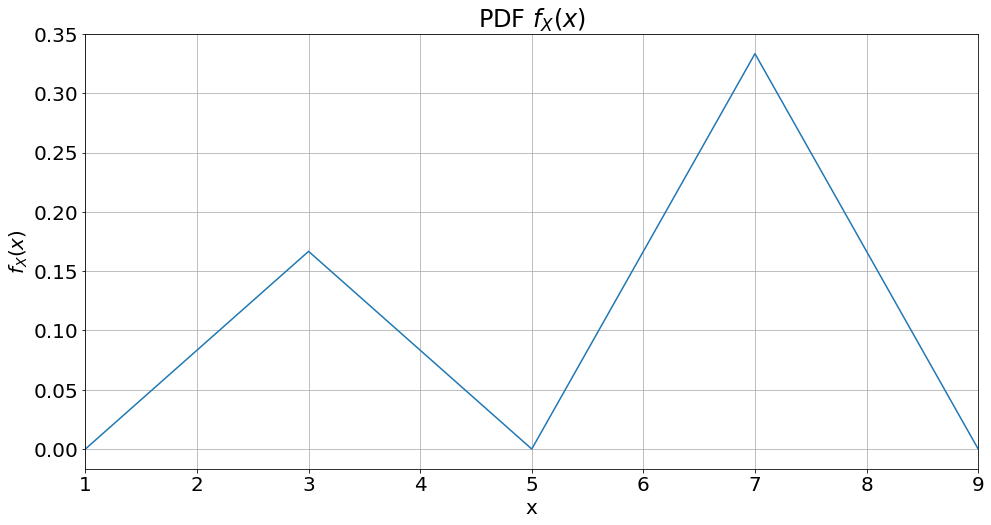

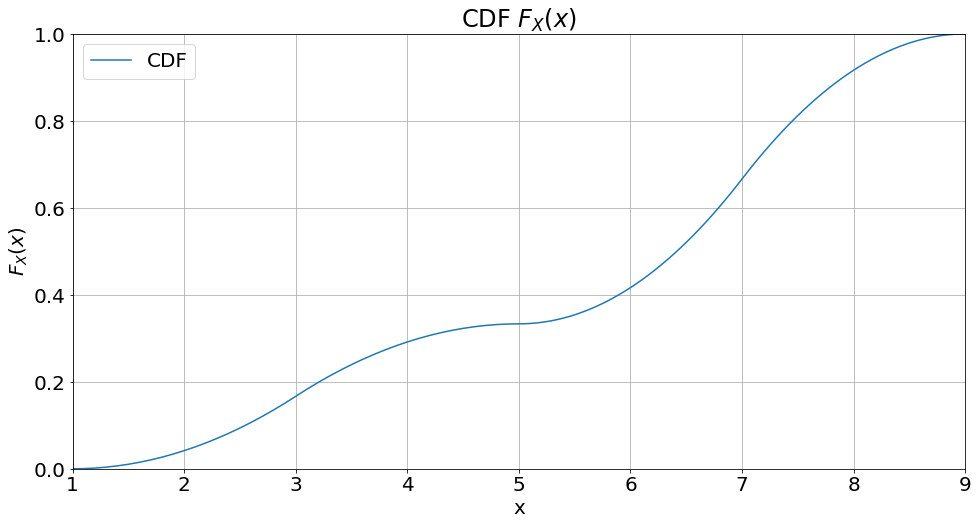

In [7]:
# 1. Visualize PDF and CDF

# Values for plots
plot_x = arange_inc(1, 9, 0.05)
plot_f = np.array([f_X(x) for x in plot_x])
plot_F = np.array([F_X(x) for x in plot_x])

# Plot the PDF f_X(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('PDF $f_X(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$f_X(x)$')
ax.set_xlim([1,9])
ax.plot(plot_x, plot_f, label='PDF')
ax.grid()
plt.show()

# Plot the CDF F_X(x)
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('CDF $F_X(x)$')
ax.set_xlabel('x')
ax.set_ylabel('$F_X(x)$')
ax.set_xlim([1,9])
ax.set_ylim([0,1])
ax.plot(plot_x, plot_F, label='CDF')
ax.legend()
ax.grid()
plt.show()

In [8]:
# 1.1 Take samples and compute expectation
def samples_x_inv_trans(F_X_inv, size):
    """
    Sample random variable X using Inverse Transform Sampling
    F_X_inv: inverse of the CDF
    size:    size of the array to generate
    """
    # Sample u uniformly on [0, 1]
    u = np.random.uniform(size=size)
    # Apply the inverse transform
    return F_X_inv(u)

# Generate 1,000,000 samples for x
sample_size: int = 10**6
x_samples_its = samples_x_inv_trans(F_X_inv, size=sample_size)
# Compute E_f[H] on these samples
exp_h_its: float = expectation_mc(h, x_samples_its)
# Report the results
print(f'Expectation of h(x) using Inverse Transform Sampling: {exp_h_its:0.6f}')

Expectation of h(x) using Inverse Transform Sampling: 0.058860


In [9]:
def samples_x_reject(f_X, size, a: float, b: float, y_max: float):
    """Sample random variable X using Rejection Sampling with a uniform proposal distribution
    f_X:   probability density function for f(x)
    size:  size of the array to generate
    a:     start of the support of f(x); left side of rectangular box
    b:     end of the support of f(x); right side of rectangular box
    y_max: maximum of f(x) on [a, b]; height of rectangular box
    """
    # Preallocate space for the drawn samples
    x_samples = np.zeros(size)
    # Count the number of samples drawn and attempts
    idx: int = 0
    attempts: int = 0
    # Continue drawing new samples until we've collected size of them
    while idx < size:
        # Draw a random value of x on [a, b]
        x = np.random.uniform(a, b)
        # Draw a random value of y on [0, y_max]; if y <= f_X(x), keep this sample
        if np.random.uniform(0, y_max) <= f_X(x):
            # Save the sample in slot idx, then increment idx
            x_samples[idx] = x
            idx += 1
        # Always increment attempts
        attempts += 1
    # Return the list of samples as well as the number of attempts
    return x_samples, attempts

# Generate samples with rejection sampling
# Maximum value of f(X) occurs at x=7
y_max: float = f_X(7)
x_samples_rs, attempts = samples_x_reject(f_X, sample_size, 1.0, 9.0, y_max)
# Report number of trials
print(f'Drew {sample_size} samples for x ~ f(x) in {attempts} attempts.')

# Compute E_f[H] on these samples
exp_h_rs: float = expectation_mc(h, x_samples_rs)
# Report the results
print(f'Expectation of h(x) using Rejection Sampling: {exp_h_rs:0.6f}')

Drew 1000000 samples for x ~ f(x) in 2663554 attempts.
Expectation of h(x) using Rejection Sampling: 0.058864


<div class="answer-separator">
------------------------
</div>

## Question 2: The Consequences of O-ring Failure can be Painful and Deadly

**Coding required**

In 1986, the space shuttle Challenger exploded during take off, killing the seven astronauts aboard. It is believed that the explosion was caused by the failure of an O-ring (a rubber ring that seals parts of the solid fuel rockets together), and that the failure was caused by the cold weather at the time of launch (31F).

In the file chall.txt, you will find temperature (in Fahrenheit) and failure data from 23 shuttle launches, where 1 stands for O-ring failure and 0 no failure. We assume that the observed temperatures are fixed and that, at temperature $t$, an O-ring fails with probability $f(\theta_{1}+\theta_{2}t)$ conditionally on $\Theta = (\theta_1, \theta_2)$.

$f(\v{z})$ is defined to be the logistic function -- $f(\v{ z }) = 1/(1 + \exp(\v{ -z }))$ 

**2.1.** Based on your own knowledge and experience, suggest a prior distribution for the regression parameters ($\theta_1, \theta_2$).  Make sure to explain your choice of prior. 

**2.2.** Produce 5000-10000 samples from the posterior distribution of $\Theta $ using rejection sampling, and plot them and their marginals. (This may take a while.)

**2.3.** Use the logit package in the `statsmodels` library to compute 68% confidence intervals on the $\theta$ parameters.  Compare those intervals with the 68% credible intervals from the posterior above. Overlay these on the above marginals plots. 

**2.4.** Use the MLE values from `statsmodels` and the posterior mean from **2.2** at each temperature to plot the probability of failure in the frequentist and bayesian settings as a function of temperature. What do you see? 

**2.5.** Compute the mean posterior probability for an O-ring failure at $t = 31^\circ F$. To do this you must calculate the posterior at $31^\circ F$ and take the mean of the samples obtained.

**2.6.** You can instead obtain the probability from the posterior predictive. Use the posterior samples to obtain samples from the posterior predictive at $31^\circ F$ and calculate the fraction of failures.

**2.7.** The day before a new launch, meteorologists predict that the temperature will be $T \sim N(68, 1)$ during take-off. Estimate the probability for an O-ring failure during this take-off. (You will calculate multiple predictives at different temperatures for this purpose).

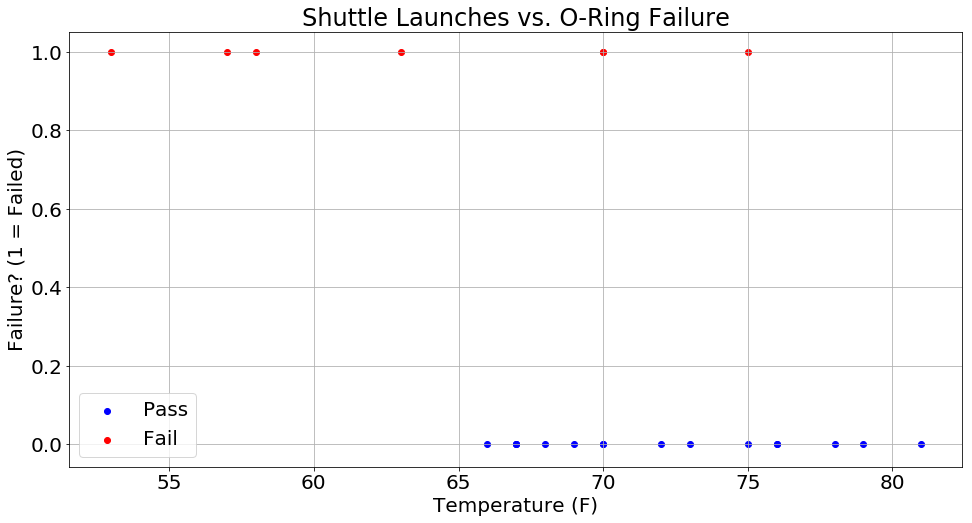

In [10]:
# 2. Visualize the data
# Download the file into a DataFrame
df = pd.read_csv('chall.txt', names=['temp', 'fail'], delim_whitespace=True, index_col=False)
# Alias into local variables
temps = df.temp.values
fails = df.fail.values
temps_pass = df[df.fail==0]['temp'].values
temps_fail = df[df.fail==1]['temp'].values

# Plot summary of data
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Shuttle Launches vs. O-Ring Failure')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Failure? (1 = Failed)')
ax.scatter(temps_pass, np.zeros_like(temps_pass), label='Pass', color='b')
ax.scatter(temps_fail, np.ones_like(temps_fail), label='Fail', color='r')
ax.legend(loc='lower left')
ax.grid()

**2.1** I rember the Challenger disaster vividly because I was nine years old when it happened and they played it endlessly on CNN.

I don't really know much about this phenomenon, so my inclination is to choose an uninformative prior.  A normal distribution seems like a good choice that is familiar and has high entropy.  I'm highly skeptical of making up parameter values for the prior without a good basis for them.  Instead, I went ahead and did the next part of this problem (please see below) and looked at the estimated parameter values for $\theta_1$ and $\theta_2$ as well as their standard errors.

The ML estimate of $\theta_1$ was 15.04, and the standard error was 7.4.  
The ML estimate of $\theta_2$ was -0.23 with a standard error of 0.11.  
Without a strong reason to the contrary, it seems a poor policy to choose a prior with a mean different form an estimate derived from the data, since that would skew the posterior away from the data towards our prior.  On the other hand, having a wider standard deviation in the prior will smear things out a bit and create a broad range of possible parameter values that can then be tuned by their likelihoods.  We will choose a standard deviation on the prior that is twice the estimated standard deviation in the logit model.  The resulting priors are as follows:

$$p(\theta_1) \sim N(15.04, 14.76)$$
$$p(\theta_2) \sim N(-0.23, 0.216)$$

In [11]:
def theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std):
    """
    Make a generic prior functrion that wraps the means and standard deviations
    theta_2_mean:       the mean of theta_1 on a normal distribution
    theta_1_std:        the standard deviation of theta_1 on a normal distribution
    theta_2_mean:       the mean of theta_2 on a normal distribution
    theta_2_std:        the standard deviation of theta_2 on a normal distribution
    """
    # Return a function of two variables
    def prior_instance(theta_1, theta_2):
        # Probability for theta_1
        theta_1_prob = norm.pdf(theta_1, loc=theta_1_mean, scale=theta_1_std)
        theta_2_prob = norm.pdf(theta_2, loc=theta_2_mean, scale=theta_2_std)
        # Return the joint probability
        return theta_1_prob * theta_2_prob
    
    # Return this function with the bound parameter values
    return prior_instance


def sample_theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std):
    """
    Draw samples for theta_1 and theta_2 on the prior distribution
    theta_2_mean:       the mean of theta_1 on a normal distribution
    theta_1_std:        the standard deviation of theta_1 on a normal distribution
    theta_2_mean:       the mean of theta_2 on a normal distribution
    theta_2_std:        the standard deviation of theta_2 on a normal distribution
    """
    def sample_instance(size: int = 1):
        # Preallocate storage; theta is an array of shape (size, 2)
        theta = np.zeros((size, 2))
        # Draw samples for theta_1 and theta_2
        theta[:, 0] = np.random.normal(loc=theta_1_mean, scale=theta_1_std, size=size)
        theta[:, 1] = np.random.normal(loc=theta_2_mean, scale=theta_2_std, size=size)
        # Return the combined theta array
        return theta

    # Return the instance with bound parameter values
    return sample_instance

# Selected parameters for priors of theta_1 and theta_2 are derived from the output of 
# the logistic regression estimate in statsmodels; 
# keep the means unchanged but inflate the standard deviations by 2.0x
theta_1_mean = 15.04
theta_1_std = 7.38*2
theta_2_mean = -0.23
theta_2_std = 0.108*2

# Create instances of the prior and its sampling function with bound parameter values
theta_prior = theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std)
sample_theta_prior = sample_theta_prior_generic(theta_1_mean, theta_1_std, theta_2_mean, theta_2_std)

In [12]:
# 2.2. Produce 5000-10000 samples from the posterior distribution of Θ using rejection sampling, 
# and plot them and their marginals. (This may take a while.)

# Functions for likelihood, posterior, and grid box for thetas
def sigmoid(z):
    """Sigmoid (logistic) function"""
    return 1.0 / (1.0 + exp(-z))

def likelihood(temps, fails, theta_1, theta_2):
    """Compute the likelihood of the data given parameter values theta_1 and theta_2"""
    # Compute the z score for each launch
    z = theta_1 + theta_2 * temps
    # Compute the sigmoid probabilities of failure at each launch
    fail_prob = sigmoid(z)
    pass_prob = 1.0 - fail_prob
    # The likelihood is the product over every launch of the probability of the predicted events
    pred_prob = fails * fail_prob + (1 - fails) * pass_prob
    return np.prod(pred_prob)


def theta_post(theta_1, theta_2):
    """Posterior probability for theta; uses theta_prior and likelihood defined above"""
    return theta_prior(theta_1, theta_2) * likelihood(temps, fails, theta_1, theta_2)

# Set minimum and maximum for theta_1 and theta_2 using a two standard deviation range
# (3 SD would be better, but it's already going to take a long time...)
theta_1_min, theta_1_max = theta_1_mean - 2*theta_1_std, theta_1_mean + 2*theta_1_std
theta_2_min, theta_2_max = theta_2_mean - 2*theta_2_std, theta_2_mean + 2*theta_2_std
# Package theta limits for readability
theta_limits = (theta_1_min, theta_1_max, theta_2_min, theta_2_max)

In [13]:
# 2.2 Estimate L_star (largest value of posterior) by sampling the prior or grid search
def L_star_sample(sample_theta_prior, sample_size):
    """Estimate L_star by sampling"""
    # pre-allocate space for the samples
    post_probs = np.zeros(sample_size)
    # Sample theta from the prior
    thetas = sample_theta_prior(sample_size)
    # Maximum posterior seen so far and accompanying theta    
    max_post_seen = 0.0
    argmax_theta = None
    # Evaluate the posterior probability on sample_size samples
    for i, theta in enumerate(thetas):        
        post_prob = theta_post(theta[0], theta[1])
        post_probs[i] = post_prob
        # Keep running track of the maximum posterior and the associated theta
        if post_prob > max_post_seen:
            max_post_seen = post_prob
            argmax_theta = theta
    # Take three summary statistics over this sample: max, mean, std
    L_max = np.max(post_probs)
    L_mean = np.mean(post_probs)
    L_std = np.std(post_probs)
    # Return summary statistics of posterior probability on this sample
    return L_max, L_mean, L_std, argmax_theta


def L_star_grid(theta_limits, grid_size):
    """Estimate L_star by building a grid"""
    # Unpack theta_limits
    theta_1_min, theta_1_max, theta_2_min, theta_2_max = theta_limits
    # Create a grid of both parameters
    theta_1_samples = np.linspace(theta_1_min, theta_1_max, num=grid_size)
    theta_2_samples = np.linspace(theta_2_min, theta_2_max, num=grid_size)
    # Maximum posterior seen so far and accompanying theta    
    max_post_seen = 0.0
    argmax_theta = None    
    # Evaluate posterior probability on the grid
    post_grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        theta_1 = theta_1_samples[i]
        for j in range(grid_size):
            theta_2 = theta_2_samples[j]
            # Save posterior probability on post_grid
            post_prob = theta_post(theta_1, theta_2)
            post_grid[i,j] = post_prob
            # Keep running track of the maximum posterior and the associated theta
            if post_prob > max_post_seen:
                max_post_seen = post_prob
                argmax_theta = np.array([theta_1, theta_2])
    # Take three summary statistics over this sample: max, mean, std
    L_max = np.max(post_grid)
    L_mean = np.mean(post_grid)
    L_std = np.std(post_grid)
    return L_max, L_mean, L_std, argmax_theta

 
# *************************************************************************************************
# Estimate the maximum posterior, L_star, and report it
if 'L_max' not in locals():
    sample_size: int = 10**5
    L_max, L_mean, L_std, argmax_theta = L_star_sample(sample_theta_prior, sample_size)
    work_per_sample = L_max / L_mean
    L_star = L_max
    msg = f'Using {sample_size} samples form the prior, maximum posterior L_max = {L_max:0.3e}, '
    msg += f'L_mean = {L_mean:0.3e}, iterations per sample = {work_per_sample:0.2f}.'
    print(msg)

if 'L_max_grid' not in locals():
    grid_size = 200
    L_max_grid, L_mean_grid, L_std_grid, argmax_theta_grid = L_star_grid(theta_limits, grid_size)  
    work_per_sample_grid = L_max_grid / L_mean_grid
    msg = f'Using a grid of size {grid_size} on the prior, maximum posterior L_max = {L_max_grid:0.3e}, '
    msg += f'L_mean = {L_mean_grid:0.3e}, iterations per sample = {work_per_sample_grid:0.3f}.'
    print(msg)

Using 100000 samples form the prior, maximum posterior L_max = 1.935e-06, L_mean = 2.663e-08, iterations per sample = 72.67.
Using a grid of size 200 on the prior, maximum posterior L_max = 1.870e-06, L_mean = 1.189e-08, iterations per sample = 157.264.


In [14]:
# 2.2 perform the sampling of theta
def sample_theta_post(theta_limits, theta_post, L_star, num_reps):
    """Sample theta_1 and theta_2 on the posterior by rejection sampling.  
    Persist samples in a CSV due to long run time."""
    # Unpack theta_limits
    theta_1_min, theta_1_max, theta_2_min, theta_2_max = theta_limits
    # Create array to store parameters
    thetas = np.zeros((num_reps, 2))    
    # Count both successes and attempts
    idx: int = 0
    attempts: int = 0
    # Status update
    bucket_size: int = 10**4
    buckets: int = 0
    # Start timer
    t0 = time.time()
    # Continue drawing theta until we have num_reps
    while idx < num_reps:
        # Draw two candidates uniformly
        theta_1 = np.random.uniform(theta_1_min, theta_1_max)
        theta_2 = np.random.uniform(theta_2_min, theta_2_max)
        # Compute the posterior
        post = theta_post(theta_1, theta_2)
        # Update L_star
        L_star = max(L_star, post)
        # Rejection sample
        if np.random.uniform(low=0, high=L_star) <= post:
            # Save this sample
            thetas[idx] = (theta_1, theta_2)
            idx += 1
        # Count the attempt
        attempts += 1
        # Status update
        if attempts >= (buckets+1) * bucket_size:
            buckets = attempts // bucket_size
            t1 = time.time()
            # Compute time used
            time_used = (t1 - t0)
            # Estimate remaining time
            time_proj = num_reps / idx * time_used if idx > 0 else np.NAN
            print(f'Completed {buckets} buckets and {idx} samples.', end=' ')
            print(f'Elapsed time {time_used:0.0f}, projected {time_proj:0.0f} seconds.')
    # Return the parameters and the number of attempts
    return (thetas, attempts)

# Test whether the posterior sample of theta was saved to file on a previous run
fname_theta_sample = 'challenger_theta_sample.csv'
if fname_theta_sample in os.listdir():
    # If it was saved, just load it
    df_theta_sample = pd.read_csv(fname_theta_sample, index_col=0)
    theta_sample = df_theta_sample.values
    num_reps = len(df_theta_sample)
    print(f'Loaded {num_reps} samples of theta drawn from posterior distribution.')
else:
    # It it wasn't save, draw samples from the posterior distribution and save them
    num_reps = 10000
    theta_sample, attempts = sample_theta_post(theta_limits, theta_post, L_star, num_reps)
    print(f'Generated {num_reps} samples from posterior distribution of theta in {attempts} attempts.')
    # Save the sampled thetas into a DataFrame
    df_theta = pd.DataFrame(data=theta_sample, columns=['theta_1', 'theta_2'])
    # Save it if not already present
    df_theta.to_csv(fname_theta_sample)
    
# Alias samples for theta_1 and theta_2 for legibility
theta_1_sample = theta_sample[:, 0]
theta_2_sample = theta_sample[:, 1]

Loaded 10000 samples of theta drawn from posterior distribution.


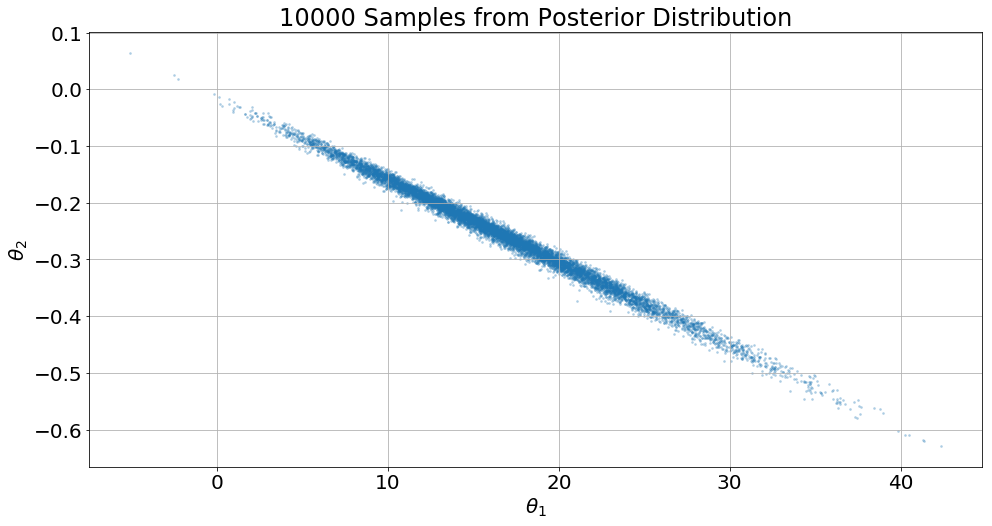

In [15]:
# Plot the sampled thetas and their marginals
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title(f'{num_reps} Samples from Posterior Distribution')
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.grid()
ax.scatter(theta_1_sample, theta_2_sample, s=3, alpha=0.25)
plt.show()

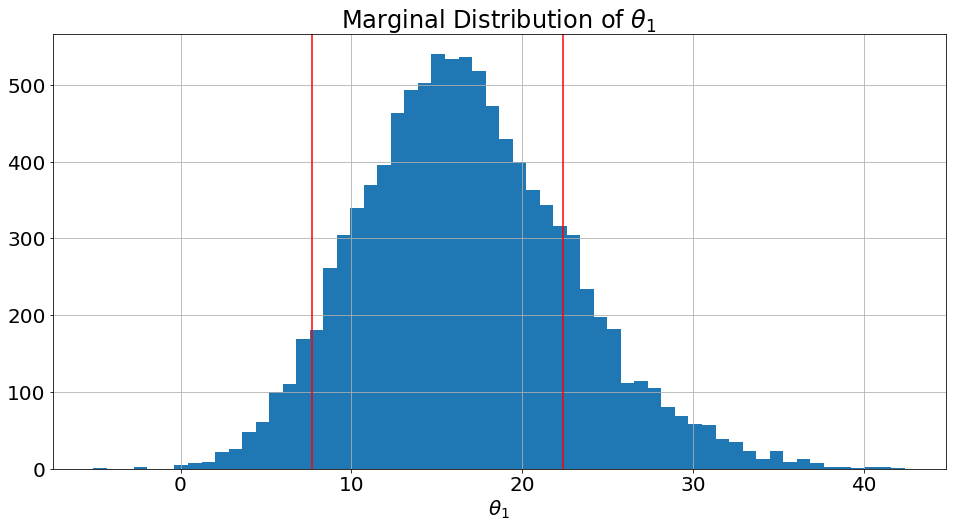

In [16]:
# Plot the marginal distribution of theta_1
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title(r'Marginal Distribution of $\theta_1$')
ax.set_xlabel(r'$\theta_1$')
ax.hist(theta_1_sample, bins=60)
# Overlay the 68% confidence interval (hard code these here)
ax.axvline(x=7.705, color='r')
ax.axvline(x=22.381, color='r')
ax.grid()
plt.show()

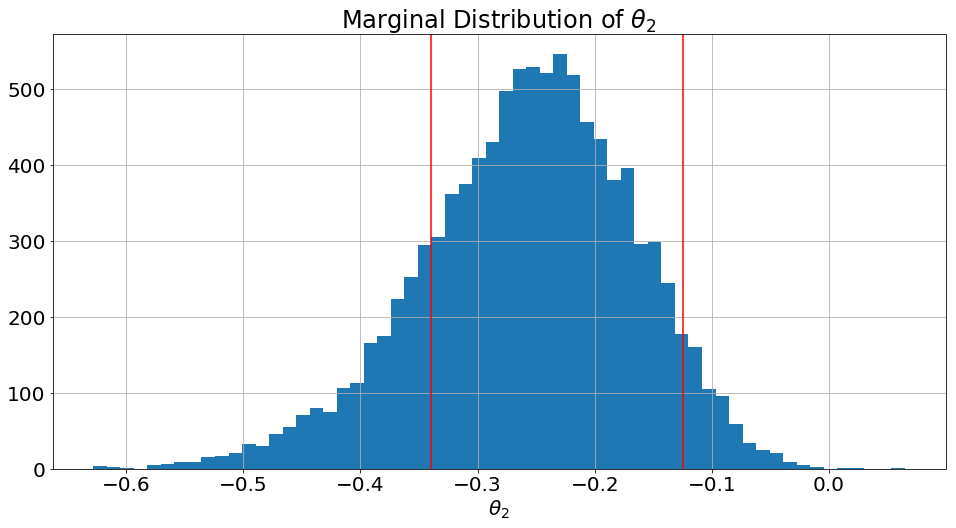

In [17]:
# Plot the marginal distribution of theta_2
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title(r'Marginal Distribution of $\theta_2$')
ax.set_xlabel(r'$\theta_2$')
ax.hist(theta_2_sample, bins=60)
# Overlay the 68% confidence interval (hard code these here)
ax.axvline(x=-0.340, color='r')
ax.axvline(x=-0.125, color='r')
ax.grid()
plt.show()

In [18]:
# 2.3. Use the logit package in the statsmodels library to compute 68% confidence intervals on the θ parameters. 
# Compare those intervals with the 68% credible intervals from the posterior above. 
# Overlay these on the above marginals plots.

# Create an array X of predictors for statsmodel including a constant
X = sm.add_constant(df.temp)
# Fit logit model
logit_model = Logit(endog=df.fail, exog=X).fit()
# Report the model summary
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
==============================================================
Model:              Logit            No. Iterations:   7.0000 
Dependent Variable: fail             Pseudo R-squared: 0.281  
Date:               2018-10-12 20:20 AIC:              24.3152
No. Observations:   23               BIC:              26.5862
Df Model:           1                Log-Likelihood:   -10.158
Df Residuals:       21               LL-Null:          -14.134
Converged:          1.0000           Scale:            1.0000 
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
const      15.0429    7.3786   2.0387  0.0415   0.5810  29.5048
temp       -0.2322    0.1082  -2.1450  0.0320  -0.4443  -0.0200
==============================================================

"""

In [19]:
# Get the parameter values from the logit model
logit_thetas = logit_model.params
# Extract the 68% confidence intervals
conf_intervals = logit_model.conf_int(alpha=0.32)
print(f'Parameter estiamtes from Logistic Regression Model (68% confidence intervals)')
print(f'68% confidence interval for theta_1 = {conf_intervals.values[0, 0]:0.3f} - {conf_intervals.values[0, 1]:0.3f}')
print(f'68% confidence interval for theta_2 = {conf_intervals.values[1, 0]:0.3f} - {conf_intervals.values[1, 1]:0.3f}')
# Get the 16th and 84th percentiles for theta_1 and theta_2
theta_1_cred = np.percentile(theta_sample[:, 0], [16, 84])
theta_2_cred = np.percentile(theta_sample[:, 1], [16, 84])
print(f'\nParameter estimates from Posterior Sampling (68% credible intervals)')
print(f'68% credible interval for theta_1   = {theta_1_cred[0]:0.3f} - {theta_1_cred[1]:0.3f}')
print(f'68% credible interval for theta_2   = {theta_2_cred[1]:0.3f} - {theta_2_cred[1]:0.3f}')

Parameter estiamtes from Logistic Regression Model (68% confidence intervals)
68% confidence interval for theta_1 = 7.705 - 22.381
68% confidence interval for theta_2 = -0.340 - -0.125

Parameter estimates from Posterior Sampling (68% credible intervals)
68% credible interval for theta_1   = 10.655 - 22.787
68% credible interval for theta_2   = -0.169 - -0.169


This is interesting.  The confidence intervals for the Bayesian estimation are meaningfully tighter than they are for the Logistic Regression model.  With that said, in broad strokes the intervals have a lot of overlap and are largely consistent.

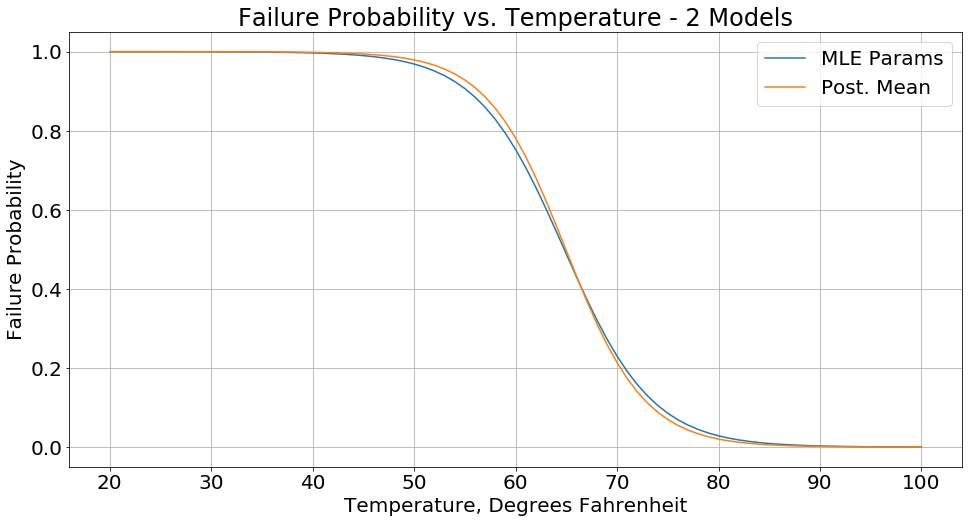

In [20]:
# 2.4. Use the MLE values from statsmodels and the posterior mean from 2.2 at each temperature to plot the probability
#  of failure in the frequentist and bayesian settings as a function of temperature. What do you see?

def fail_prob(theta_1, theta_2, temp):
    """The probability of failure at this temperature given theta_1 and theta_2"""
    z = theta_1 + theta_2 * temp
    return sigmoid(z)

# Vector of temperatures to test
plot_temp = arange_inc(20, 100)
# Alias the MLE estimates for legibility
theta_1_mle, theta_2_mle = logit_thetas
# Compute the posterior means for theta_1 and theta_2
theta_1_pm = np.mean(theta_1_sample)
theta_2_pm = np.mean(theta_2_sample)
# Compute the failure probability vs. temperature in both models
plot_fail_mle = fail_prob(theta_1_mle, theta_2_mle, plot_temp)
plot_fail_pm = fail_prob(theta_1_pm, theta_2_pm, plot_temp)

# Plot the two curves of failure probability vs. temperature
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Failure Probability vs. Temperature - 2 Models')
ax.set_xlabel('Temperature, Degrees Fahrenheit')
ax.set_ylabel('Failure Probability')
ax.plot(plot_temp, plot_fail_mle, label='MLE Params')
ax.plot(plot_temp, plot_fail_pm, label='Post. Mean')
ax.legend()
ax.grid()
plt.show()

When we collapse the Bayesian approach down to a point estimate for the parameters (i.e. the posterior mean), the two modeling approaches produce charts that look essentially identical.  This isn't surprising.  I would expect that the Bayesian methodology might be more different if we incorporated the full distribution.

In [21]:
# 2.5. Compute the mean posterior probability for an O-ring failure at t=31∘F. 
# To do this you must calculate the posterior at 31∘F and take the mean of the samples obtained.

# Set the temperature
temp_cold = 31
# Compute the failure probability using the posterior mean parameter estimates
fail_prob_pm = fail_prob(theta_1_pm, theta_2_pm, temp_cold)
print(f'The posterior mean probability of failure for a cold launch at {temp_cold} Fahrenheit '
      f'is {fail_prob_pm*100:0.1f}%')

The posterior mean probability of failure for a cold launch at 31 Fahrenheit is 100.0%


In [22]:
# 2.6. You can instead obtain the probability from the posterior predictive. 
# Use the posterior samples to obtain samples from the posterior predictive at 31∘F 
# and calculate the fraction of failures.

# For each pair (theta_1, theta_2) compute the failure probability at the cold temperature
# Then take the mean of these posterior predictives.
fail_prob_pp = np.mean([fail_prob(theta_1, theta_2, temp_cold) for theta_1, theta_2 in theta_sample])
print(f'The posterior predictive probability of failure for a cold launch at {temp_cold} Fahrenheit '
      f'is {fail_prob_pp*100:0.1f}%')

The posterior predictive probability of failure for a cold launch at 31 Fahrenheit is 99.3%


In [23]:
# Take 10000 samples of the temperature
temp_forecast_samples = np.random.normal(loc=68, scale=1,size=num_reps)
# Compute 10000 failure probabilities, each one a draw of theta from the posterior against a temperature draw
fail_probs_fc = np.zeros(num_reps)
for i in range(num_reps):
    # Get paired theta values and temperature in this simulation
    theta_1, theta_2 = theta_sample[i]
    temp = temp_forecast_samples[i]
    fail = fail_prob(theta_1, theta_2, temp)
    fail_probs_fc[i] = fail
# The estimated probability is the mean of these sampled probabilities
fail_prob_fc = np.mean(fail_probs_fc)
# Report results
print(f'Estimated mean failure probability for a launch with temperature forecast to be '\
      f'normal with mean=68, std dev = 1 is {fail_prob_fc*100:0.1f}%.')

Estimated mean failure probability for a launch with temperature forecast to be normal with mean=68, std dev = 1 is 32.8%.


<div class="answer-separator">
------------------------
</div>

## Question 3: Maximum Uniformity -- Frequentist Bootstraps and the Bayesian Posterior

**Coding required**

Recall in HW 3 Question 1 we attempted to explore an edge case in using non-parametric bootstrap to construct confidence intervals.  Let's revisit the setup of that problem.
Suppose you have $\{X_1, X_2, ... X_n\}$ datapoints such that $X_i$ are independently and identically drawn from a $Unif(0, \theta)$.  Consider the extreme order statistic Y = $X_{(n)}$ = max($X_1, X_2, ... X_n$).

**3.1.** Derive (or possibly re-write from HW3) expressions for $F_Y(y\ \vert\ n, \theta)$ the CDF of Y and $f_Y(y\ |\ n, \theta)$ the pdf of Y.

**3.2.** In HW3 we had difficulty constructing confidence intervals to estimate $\theta$ using our normal percentiles methods so instead we introduced pivot confidence intervals.  Let's reframe the problem so that we can use percentiles to construct our confidence intervals.  Define $Z \equiv n \cdot (\theta - Y)$ and use elementary calculation to write an expression for $F_Z(z\ \vert\ n, \theta)$ the CDF of $Z$ and $f_Z(z\ \vert\ n, \theta)$ the pdf of Z.

**3.3.** What is the limiting distribution of Z (as $n \rightarrow \infty$)?  Plot that limiting distribution.

**3.4.** Use scipy/numpy to generate 100000 samples {$X_i$} from Unif(0,100) (i.e. let $\theta$ = 100).  Store them in Based on your data sample, what's $\hat{\theta}$ the empirical estimate for $\theta$.

**3.5.** Use non-parametric bootstrap to generate a sampling distribution of 10000 estimates for $Z$ by substituting $\hat{\theta}$ for $\theta$.  Plot a histogram of your sampling distribution.  Make sure to title and label the plot.  Use percentiles to construct the 10% and 68% bootstrap confidence intervals.  Plot them in your graph.

**Hint:  Should the confidence intervals be symmetric around the estimate $\hat{\theta}$**?

**3.6.** Make an argument that we can construct a bootstrap confidence interval that always mismatches the limiting distribution.

**3.7.** Let's switch to being Bayesian.  In 3.1 we came up with an expression for the likelihood $f_Y(y\ |\ n, \theta)$.  Use the [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) to construct a prior for $\theta$.  What are some reasonable values to use for the scale and shape?

**3.8.** Write down an expression for the posterior distribution $f_Y(\theta\ |\ n, y)$ 

**3.9.** Draw 10000 posterior samples and plot a histogram of the posterior distribution.  Use percentiles to construct the 68% HPD.  Plot the posterior distribution and mark the HPD on your plot.

**3.10.** How does the 68% HPD compare with the confidence interval generated from bootstrapping?  Why doesn't the bayesian interval construction suffer the same concerns you noted in 3.6

**3.1** 
*Solution provided by Patrick on on Piazza - thanks!*

Let $X_1$, $X_2$,...$X_n$ be uniform random variables such that $X_i$∼Unif(0,θ). 

Let the random variable $Y$ = max($X_1$,$X_2$,...$X_n$) attain the value y with 0 < y < θ.

If $F_Y(y)$ is the CDF of $Y$, then
$$F_Y(y|\theta) = \prod_{i=1}^{n} P(X_i < y) = \prod_{i=1}^{n} \frac{y}{\theta} = 
\left(\frac{y}{\theta}\right)^n$$

We get the PDF by differentiating the CDF:
$$f_Y(y|\theta) = \frac{d}{d\theta} \left(\frac{y}{\theta}\right)^n =
n\left(\frac{y^{n-1}}{\theta^n}\right)$$


**3.2**
First solve for $Y$ in terms of $Z$.  $\theta - Y = Z / n$ so
$$Y = \theta - \frac{Z}{n}$$
Now we can evaluate the CDF for $Z$ by a simple subsitution into the CDF for $Y$
$$F_Z(Z) = F_Y\left(\theta - \frac{Z}{n}\right) = 1 - \left(\frac{\theta-Z/N}{\theta}\right)^n = 
1 - \left(1 - \frac{Z}{n\theta}\right)^n$$
The PDF is just the derivative of $F_Z(Z)$ with respect ot $Z$:
$$f_Z(Z) = \frac{d}{dZ} F_Z(Z) = -n\left(1 - \frac{Z}{n\theta}\right)^{n-1}\left(\frac{-1}{n\theta}\right) = 
\left(\frac{1}{\theta}\right) \left(1 - \frac{Z}{n\theta}\right)^{n-1}$$

**3.3**
Recall from high school calculus the "continuous compound interest formula" that for a real number $x$, the limit
$$\lim_{n\rightarrow\infty} = \left(1+\frac{x}{n}\right)^n = \exp(x)$$
Identify $x = \frac{-Z}{\theta}$.  We can see that in the limit as $n \rightarrow \infty$,
$$F_Z(Z) = 1 - \exp\left(\frac{-Z}{\theta}\right)$$ and
$$f_Z(Z) =  \left(\frac{1}{\theta}\right)\exp\left(\frac{-Z}{\theta}\right)$$

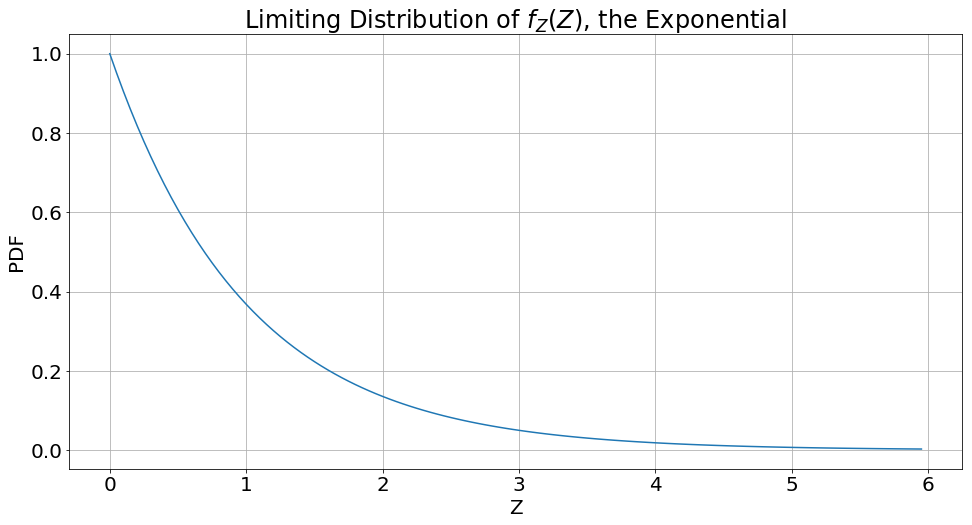

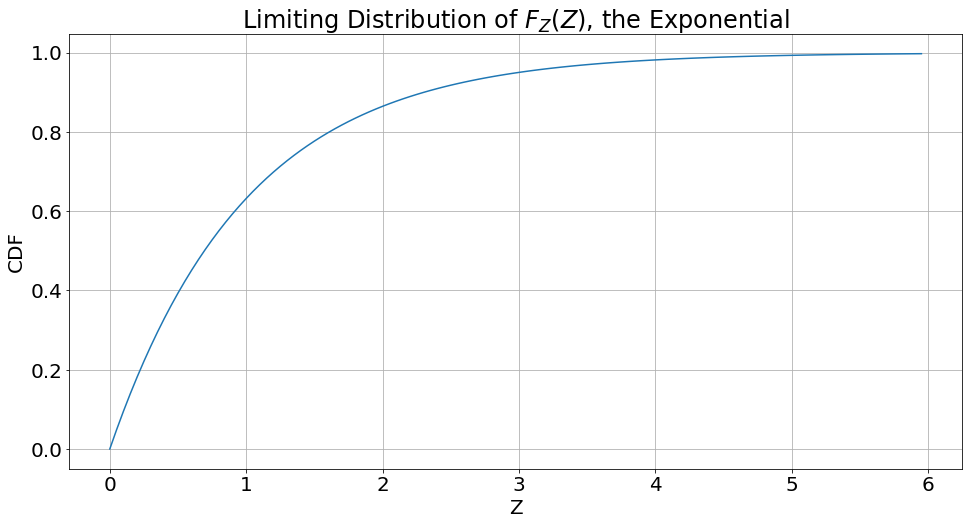

In [29]:
# 3.3 Plot the exponential distribution

# Generate an example exponential distribution
plot_x = np.arange(0, 6, 0.05)
plot_pdf = expon.pdf(plot_x, loc=0, scale=1)
plot_cdf = expon.cdf(plot_x, loc=0, scale=1)

# Plot the PDF
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Limiting Distribution of $f_Z(Z)$, the Exponential')
ax.set_xlabel('Z')
ax.set_ylabel('PDF')
ax.plot(plot_x, plot_pdf)
ax.grid()
plt.show()

# Plot the CDF
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Limiting Distribution of $F_Z(Z)$, the Exponential')
ax.set_xlabel('Z')
ax.set_ylabel('CDF')
ax.plot(plot_x, plot_cdf)
ax.grid()
plt.show()

<div class="answer-separator">
------------------------
</div>

In [33]:
# 3.4. Use scipy/numpy to generate 100000 samples {Xi} from Unif(0,100) (i.e. let θ = 100). 
# Store them in Based on your data sample, what's θ̂ the empirical estimate for θ.

# Number of samples requested
sample_size = 100000
# Given value of theta
theta = 100
# Set the random seed
np.random.seed(42)
# Build samples with numpy
x_samples = np.random.uniform(low=0.0, high=theta, size=sample_size)
# The empirical estimate is just the maximum
theta_hat_ml = np.max(x_samples)
print(f'Sample size = {sample_size}, ML estimate of theta = {theta_hat_ml:0.6f}.')

Sample size = 100000, ML estimate of theta = 99.999204.


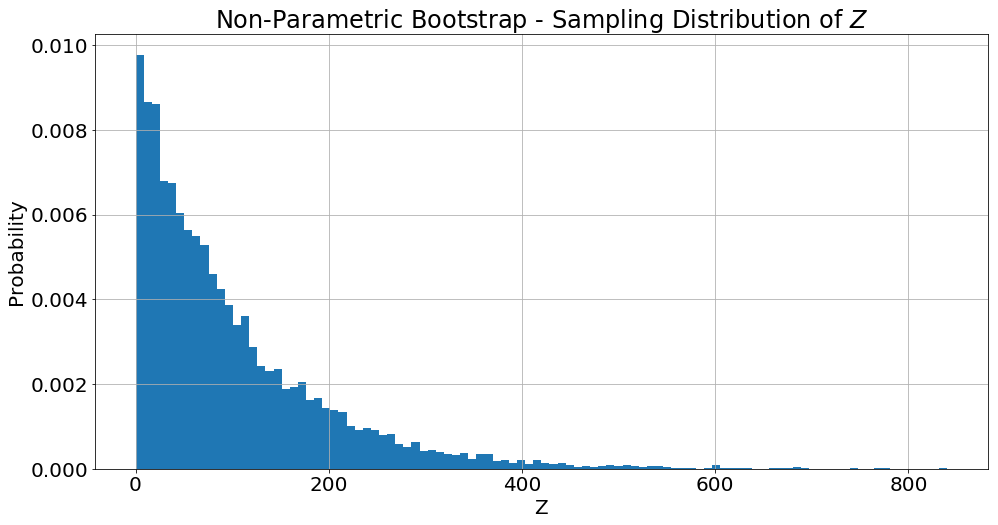

In [34]:
# 3.5. Use non-parametric bootstrap to generate a sampling distribution of 10000 estimates for Z by substituting 
# θ^ for θ. Plot a histogram of your sampling distribution. Make sure to title and label the plot. 
# Use percentiles to construct the 10% and 68% bootstrap confidence intervals. Plot them in your graph.
# Hint: Should the confidence intervals be symmetric around the estimate θ^?

# Generate samples of z with the ML estimate of theta
z_samples = np.random.exponential(scale=theta_hat_ml, size=10000)
# Plot the histogram
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title('Non-Parametric Bootstrap - Sampling Distribution of $Z$')
ax.set_xlabel('Z')
ax.set_ylabel('Probability')
ax.hist(z_samples, bins=100, density=True)
ax.grid()
plt.show()

**3.6**

**3.7** The Pareto Distribution has PDF
$$f(x) = \frac{\alpha {x_m}^\alpha}{x^{\alpha+1}}$$
where $x_m$ is the minimum value of $x$ and the support is on $[x_m, \infty)$.
In this case, a natural choice for the parameter $\theta_m$, the minimum value of $\theta$ in the prior $f(\theta)$, is $y$, since we know $\theta$ is at least the largest value seen..  A natural prior for the scale factor $\alpha$ is 2.  This corresponds to 1 "pseudo-observation" of a data draw with value $y$.  That is, 
$$f(\theta) = \frac{y}{\theta^2} \text{ on } [y, \infty)$$

**3.8** This useful page on Wikipedia contains the standard result that the Pareto Distribution is the conjugate prior for the maximum of $k$ draws from a uniform distribution $U([0, \theta]$.
https://en.wikipedia.org/wiki/Conjugate_prior

The posterior distribution updates the prior by replacing the minimum value $x_m$ with the maximum seen, and the parameter $k$ with the number of draws by the number of data points drawn.  In this case, the posterior becomes
$$f(\theta) = \frac{n y}{\theta^{n+1}} \text{ on } [y, \infty)$$

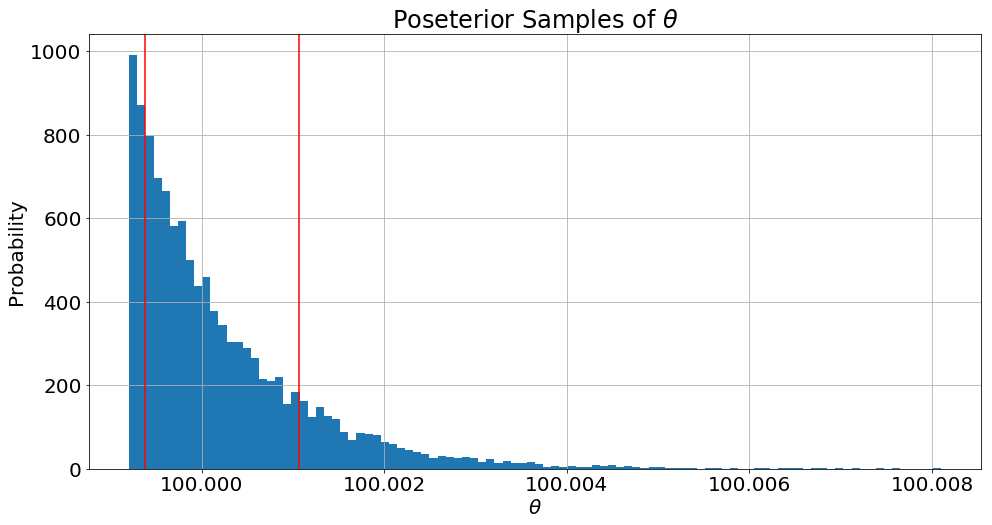

In [35]:
# 3.9. Draw 10000 posterior samples and plot a histogram of the posterior distribution. 
# Use percentiles to construct the 68% HPD. Plot the posterior distribution and mark the HPD on your plot.

# Number of samples
n: int = len(x_samples)
# Draw 10,000 samples from the posterior, a pareto with shape=n+1 and scale = theta_hat
# As per the numpy documentation, the library function is for the 
theta_samples = theta_hat_ml * (1+np.random.pareto(a=n+1, size=10000))
# The 68% range spans percentiles 16 to 84
theta_lo, theta_hi = np.percentile(theta_samples, q=[16, 84])
# Plot the posterior distribution with the HPD marked
fig, ax = plt.subplots()
fig.set_size_inches([16, 8])
ax.set_title(r'Poseterior Samples of $\theta$')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Probability')
# Turn off axis shifting so we can see a regular scale
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.hist(theta_samples, bins=100, density=True)
ax.axvline(theta_lo, color='r')
ax.axvline(theta_hi, color='r')
ax.grid()
plt.show()

**3.10** On Homework 3 we saw that the the maximum likelihood estimate $\theta_{ML}$, the maximum $y$ of the samples, would always be slightly lower than the true value of $\theta$.  A simple bootstrapping approach won't help because adding copies with replacement will never increase the maximum greater than $y$.  The Bayesian procedure did way better! The true figure of 100 is right in the middle of the 68% confidence interval.

Why does the Bayesian procedure handle this so much better? Because it's using an entire distribution of parameter values rather than trying to compress everything down to a point estimate.  For many applications, using a point estimate in lieu of the whole distribution doesn't change the estimate by that much, e.g. taking expectations.  But in this case of taking the extreme order statistic, the deficiencies of a naive frequentist approach are amplified.  The Bayesian approach is smearing everything out and when the priors are adjusted to posteriors based on the observed data, we see a high probability the parameter theta is slightly lower than the true value, with a long tail crossing the true value and then decaying as we get past it.